# Gridpoint env precursor analysis


* So far using CAPE/TCWV, 4x shear
  * low, mid, high, deep.
* 1d/2d histograms
* Filter on fractional growth rate values.
* My initial impressions are that neither CAPE nor TCWV are strongly correlated with MCS area, or growth rates.
* CAPE does seem to have some link to growth, when subsetting CAPE to growing MCSs
* Subset tracks to tropics/equator
* Shear does not seem to be a good predictor of growth/decay
* CAPE vs duration/area does not show anything that notable yet.


* 19/8/22: Initial work. Basic match up of tracks data and era5 tracks linked data.
* 31/8/22: Intial shear analysis.
* 9/9/22: Restructure code and do tropics/equator subsetting/stratification.
* 9/9/22: Add in CAPE vs duration, CAPE vs area 2D hists.

In [1]:
from pathlib import Path

import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS

from remake import load_remake

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])
ntracks = len(tracks.dstracks.tracks)

In [3]:
# Produced by remakefiles/track_era5_env_precursor.py
track_era5 = xr.open_dataset(PATHS['datadir'] / 'mcs_prime_output/track_era5_env_precursor/2019' / 'daily_track_era5_data_2019.nc')

In [4]:
teep = load_remake('../../remakefiles/track_era5_env_precursor.py')

In [5]:
task_shear = teep.CombineTrackERA5EnvPrecursor.tasks.filter(year=2019, datatype='shear')[0]
task_2D = teep.CombineTrackERA5EnvPrecursor.tasks.filter(year=2019, datatype='2D')[0]

In [6]:
path_shear = task_shear.outputs['track_era5_data']
path_2D = task_2D.outputs['track_era5_data']
for path in [path_shear, path_2D]:
    print(path.exists())

True
True


In [7]:
# Produced by remakefiles/track_era5_env_precursor.py
track_era5 = xr.open_dataset(path_2D)
track_era5uv = xr.open_dataset(path_shear)

In [8]:
track_era5

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
Data variables:
    cape     (tracks, times) float32 ...
    tcwv     (tracks, times) float32 ...

In [9]:
track_era5uv

<xarray.Dataset>
Dimensions:  (tracks: 32843, times: 400, level: 4)
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 ... 32837 32838 32839 32840 32841 32842
  * times    (times) int64 0 1 2 3 4 5 6 7 8 ... 392 393 394 395 396 397 398 399
  * level    (level) int64 133 111 96 74
Data variables:
    u        (tracks, times, level) float64 ...
    v        (tracks, times, level) float64 ...

In [10]:
mask = ~np.isnan(track_era5.cape)
tmask = ~np.isnan(tracks.dstracks.area)
(mask.values == tmask.values).all()

True

# Plot some basic data

* Histograms of CAPE/TCWV conditional on where an MCS is.

In [11]:
def plot_hist(title, units, data, mask, bins):
    plt.figure(title)
    plt.title(title)
    plt.hist(data[mask], bins=bins)
    plt.xlabel(units)
    

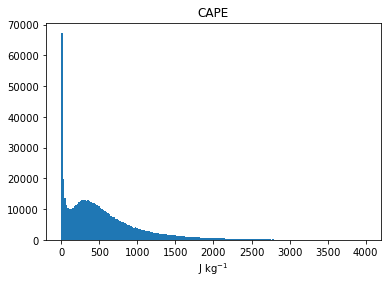

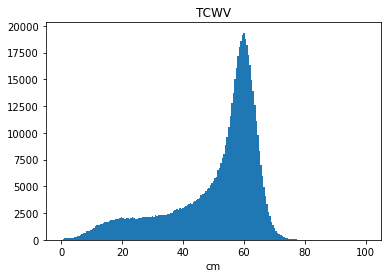

In [12]:
plot_hist('CAPE', 'J kg$^{-1}$', track_era5.cape.values, mask, bins=np.linspace(0, 4000, 200))
plot_hist('TCWV', 'cm', track_era5.tcwv.values, mask, bins=np.linspace(0, 100, 200))


Large spike at CAPE=0

In [13]:
# Subset some tracks based on their lat.

tracks.dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    tropical_mask = ((tracks.dstracks.meanlat.values > -20) & (tracks.dstracks.meanlat.values < 20)).any(axis=1)
    eq_mask = ((tracks.dstracks.meanlat.values > -5) & (tracks.dstracks.meanlat.values < 5)).any(axis=1)
    dstracks_tropical = tracks.dstracks.isel(tracks=tropical_mask)
    dstracks_eq = tracks.dstracks.isel(tracks=eq_mask)
    
    track_era5_tropical = track_era5.sel(tracks=tropical_mask)
    track_era5_eq = track_era5.sel(tracks=eq_mask)
    track_era5uv_tropical = track_era5uv.sel(tracks=tropical_mask)
    track_era5uv_eq = track_era5uv.sel(tracks=eq_mask)

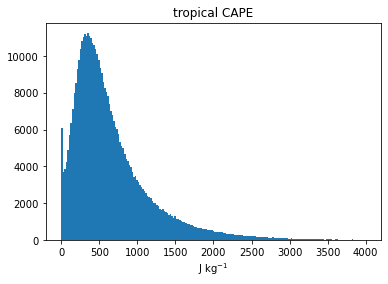

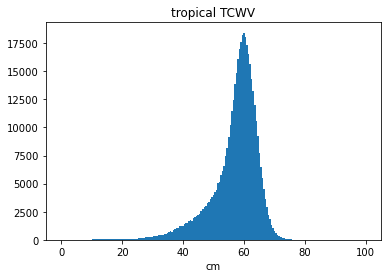

In [14]:
mask = ~np.isnan(track_era5_tropical.cape)

plot_hist('tropical CAPE', 'J kg$^{-1}$', track_era5_tropical.cape.values, mask, bins=np.linspace(0, 4000, 200))
plot_hist('tropical TCWV', 'cm', track_era5_tropical.tcwv.values, mask, bins=np.linspace(0, 100, 200))

# Perform growth/stable/decay analysis

Idea, use fractional area growth, $\frac{1}{A}\frac{dA}{dt}$ -> $\frac{1}{A^{n+1}}\frac{A^{n+1} - A^n}{\Delta t}$ to stratify environmental conditions where MCSs present.

In [15]:
def calc_frac_growth(dstracks):
    mask = ~np.isnan(dstracks.area)

    dt = 1
    fractional_area_growth = dstracks.area.values.copy()
    fractional_area_growth[:, 1:] = (1 / dstracks.area[:, 1:].values) * ((dstracks.area[:, 1:].values - dstracks.area[:, :-1].values) / dt)
    area_mask = mask.copy()
    area_mask[:, 0] = False
    return fractional_area_growth, area_mask

def calc_growth_masks(fractional_area_growth, thresh=0.1):
    growth_mask = fractional_area_growth >= 0.1
    stable_mask = (fractional_area_growth > -0.1) & (fractional_area_growth < 0.1)
    decay_mask = fractional_area_growth <= 0.1
    
    return growth_mask, stable_mask, decay_mask

In [16]:
def plot_growth_hists(title, units, data, mask, growth_mask, stable_mask, decay_mask, bins):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
        plot_data = data[m & mask]
        mean = plot_data.mean()
        p = plt.hist(plot_data, bins=bins, histtype='step', density=True, label=l, color=c);
        plt.axvline(x=mean, color=c)
        print(title, l, mean)
    plt.xlabel(units)
    plt.legend()

CAPE growth 626.70746
CAPE stable 506.33514
CAPE decay 518.95575
TCWV growth 51.07359
TCWV stable 50.463272
TCWV decay 50.300705


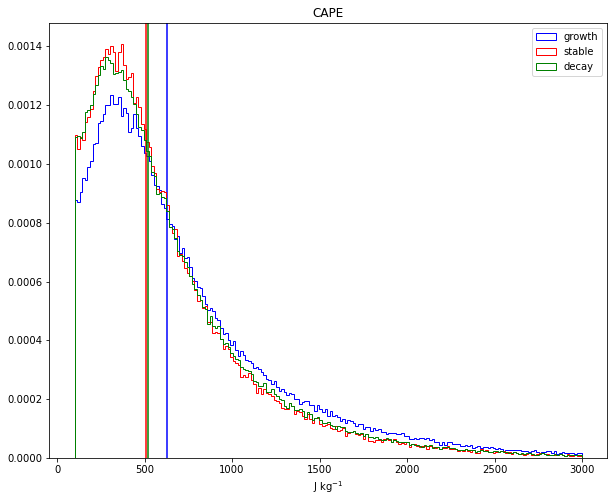

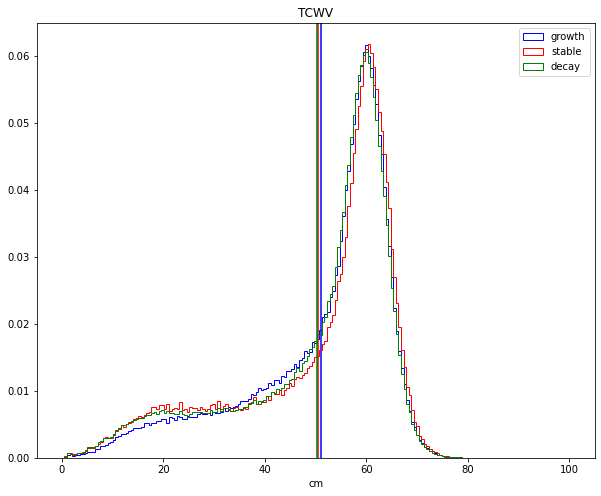

In [17]:
mask = ~np.isnan(track_era5.cape)

fag, fag_mask = calc_frac_growth(tracks.dstracks)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)
plot_growth_hists('CAPE', 'J kg$^{-1}$', track_era5.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(100, 3000, 200))
plot_growth_hists('TCWV', 'cm', track_era5.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

tropical CAPE growth 716.46246
tropical CAPE stable 623.59467
tropical CAPE decay 621.2461
tropical TCWV growth 56.894245
tropical TCWV stable 58.180523
tropical TCWV decay 57.168552


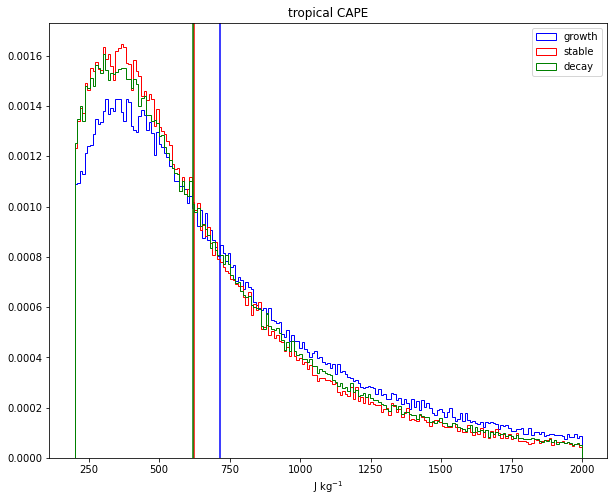

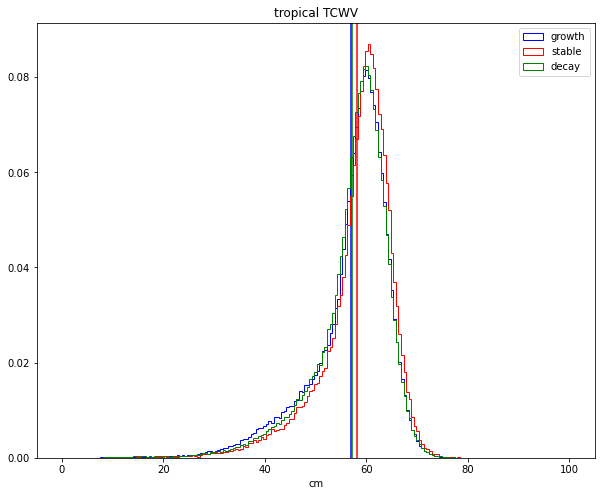

In [18]:
mask = ~np.isnan(track_era5_tropical.cape)
fag, fag_mask = calc_frac_growth(dstracks_tropical)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)
plot_growth_hists('tropical CAPE', 'J kg$^{-1}$', track_era5_tropical.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(200, 2000, 200))
plot_growth_hists('tropical TCWV', 'cm', track_era5_tropical.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

equator CAPE growth 707.2536
equator CAPE stable 611.781
equator CAPE decay 602.48413
equator TCWV growth 57.21349
equator TCWV stable 58.41428
equator TCWV decay 57.55161


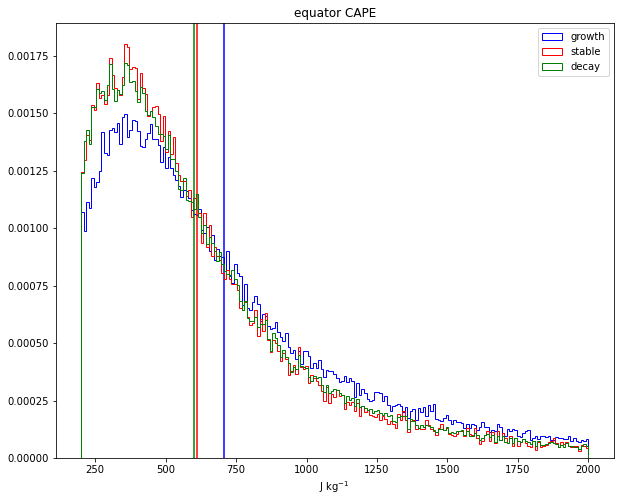

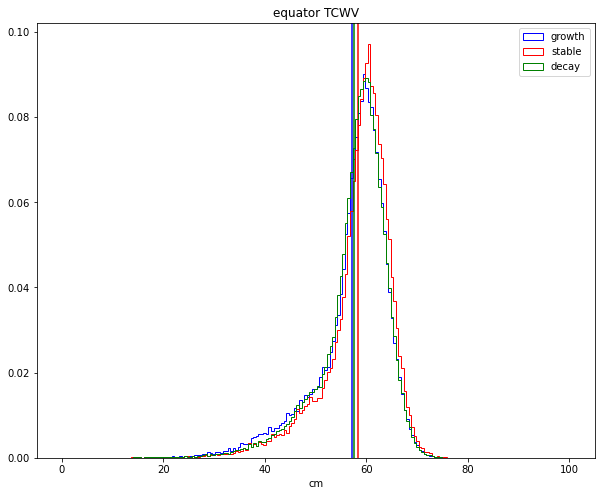

In [19]:
mask = ~np.isnan(track_era5_eq.cape)
fag, fag_mask = calc_frac_growth(dstracks_eq)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)
plot_growth_hists('equator CAPE', 'J kg$^{-1}$', track_era5_eq.cape.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(200, 2000, 200))
plot_growth_hists('equator TCWV', 'cm', track_era5_eq.tcwv.values, mask, growth_mask, stable_mask, decay_mask, np.linspace(0, 100, 200))

In [20]:
def plot_shear(title, shear, mask, growth_mask, stable_mask, decay_mask, n=4):
    titles = {0: 'lls', 1: 'mls', 2: 'hls', 3: 'ds'}
    for i in range(n):
        plot_growth_hists(title + ' ' +titles[i], 'm s$^{-1}$', shear[:, :, i], mask, growth_mask, stable_mask, decay_mask, bins=np.linspace(0, 40, 200))

In [21]:
def calc_shear(track_era5uv):
    track_era5uv.u.load()
    track_era5uv.v.load()
    u = track_era5uv.u.values
    v = track_era5uv.v.values
    # Calc LLS, MLS, HLS, DS in one line.
    # LLS = shear[:, :, 0]
    # MLS = shear[:, :, 1]
    # HLS = shear[:, :, 2]
    # DS = shear[:, :, 3]
    shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
    return shear
    # lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [22]:
shear = calc_shear(track_era5uv)

full lls growth 5.680047077342577
full lls stable 6.221988307828728
full lls decay 6.030199933575322
full mls growth 6.957994987643757
full mls stable 7.520373498970511
full mls decay 7.19984129593576
full hls growth 12.354245765957435
full hls stable 12.78176294737877
full hls decay 12.42791721499283
full ds growth 17.48010726042348
full ds stable 18.761067030324515
full ds decay 17.799954003304727


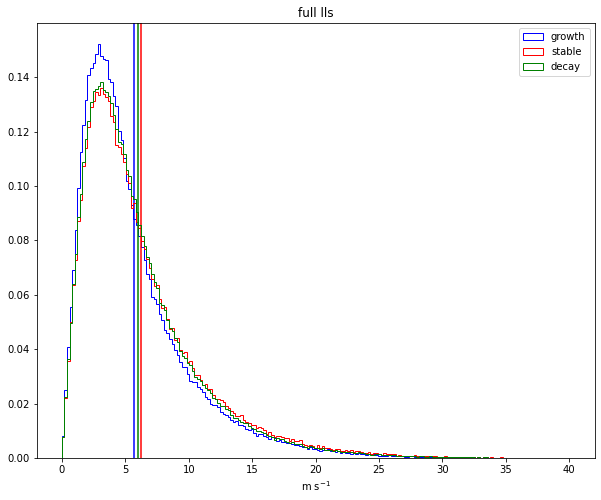

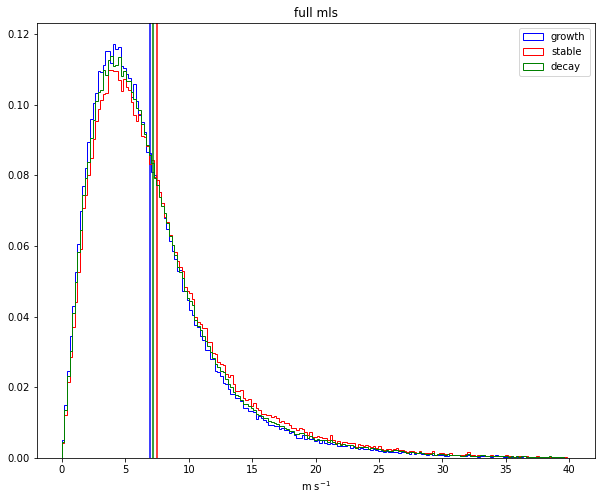

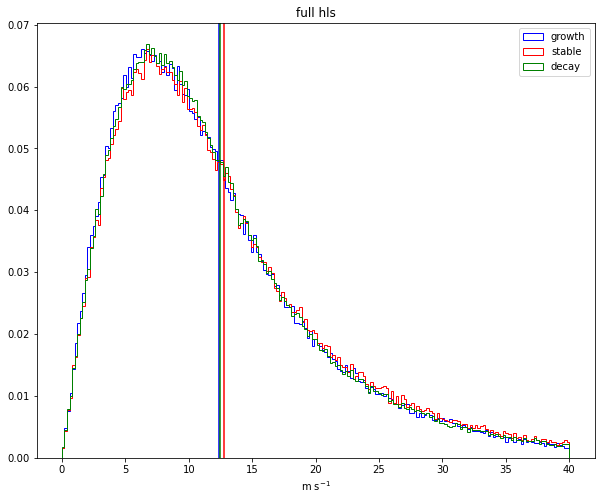

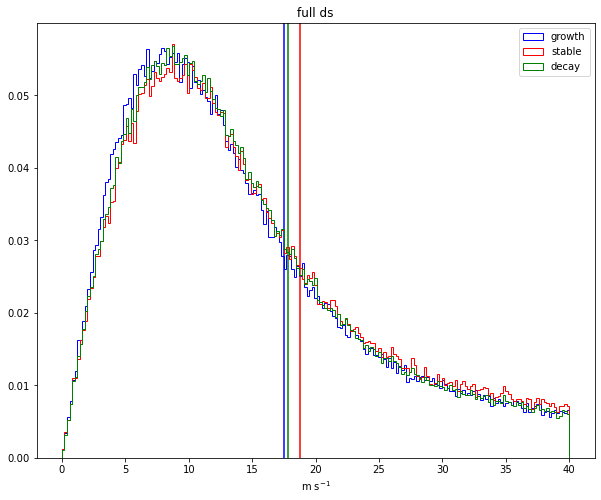

In [23]:
fag, fag_mask = calc_frac_growth(tracks.dstracks)
growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)
plot_shear('full', shear, fag_mask, growth_mask, stable_mask, decay_mask)

In [ ]:
# DO NOT KNOW WHY THESE HAVE STOPPED WORKING!
# Cannot even get u values.
# u = track_era5uv_tropical.u.values
if False:
    fag, fag_mask = calc_frac_growth(dstracks_tropical)
    growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)

    shear = calc_shear(track_era5uv_tropical)
    plot_shear('tropical', shear, fag_mask, growth_mask, stable_mask, decay_mask)

In [25]:
if False:
    fag, fag_mask = calc_frac_growth(dstracks_eq)
    growth_mask, stable_mask, decay_mask = calc_growth_masks(fag)

    shear = calc_shear(track_era5uv_eq)
    plot_shear('equatorial', shear, fag_mask, growth_mask, stable_mask, decay_mask)

# 2D histograms

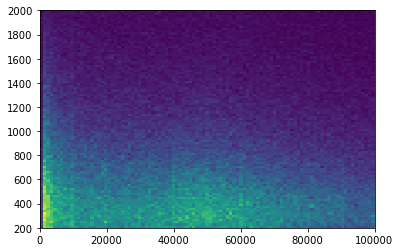

In [26]:
mask = ~np.isnan(track_era5.cape)

plt.hist2d(tracks.dstracks.area.values[mask], track_era5.cape.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(200, 2000, 100)));

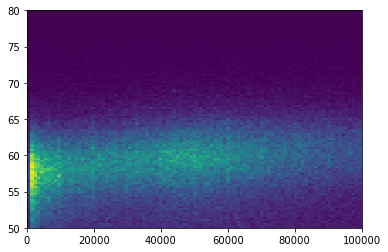

In [27]:
plt.hist2d(tracks.dstracks.area.values[mask], track_era5.tcwv.values[mask], bins=(np.linspace(0, 1e5, 100), np.linspace(50, 80, 100)));

In [28]:
dt = 1
fractional_area_growth = tracks.dstracks.area.values.copy()
fractional_area_growth[:, 1:] = (1 / tracks.dstracks.area[:, 1:].values) * ((tracks.dstracks.area[:, 1:].values - tracks.dstracks.area[:, :-1].values) / dt)

In [29]:
area_mask = mask.copy()
area_mask[:, 0] = False

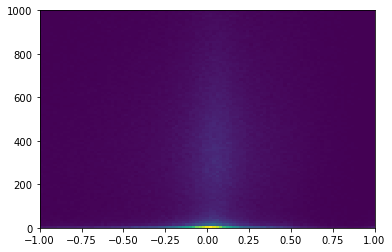

In [30]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(0, 1000, 100)));

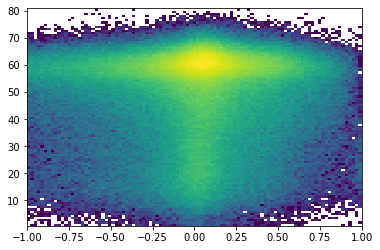

In [31]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.tcwv.values[area_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

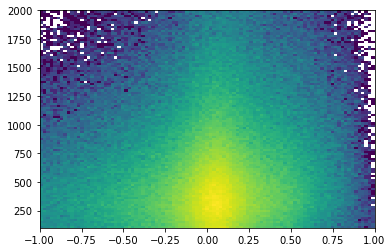

In [32]:
plt.hist2d(fractional_area_growth[area_mask], track_era5.cape.values[area_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

In [33]:
early_mask = area_mask.copy()
early_mask[:, 4:] = False

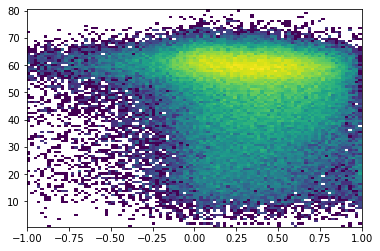

In [34]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.tcwv.values[early_mask], bins=(np.linspace(-1, 1, 100), 100), norm=LogNorm());

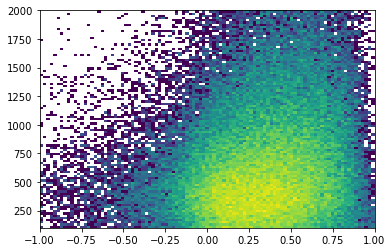

In [35]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)), norm=LogNorm());

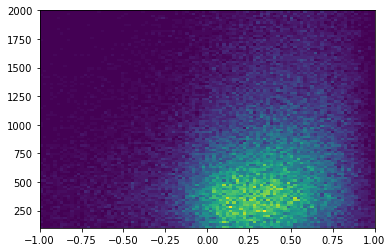

In [36]:
plt.hist2d(fractional_area_growth[early_mask], track_era5.cape.values[early_mask], bins=(np.linspace(-1, 1, 100), np.linspace(100, 2000, 100)));

# Experimental

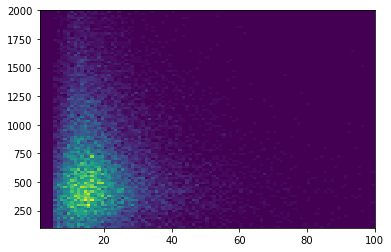

In [37]:
# mean CAPE vs duration.
plt.hist2d(tracks.dstracks.track_duration.values, np.nanmean(track_era5.cape.values, axis=1), bins=(np.linspace(1, 100, 100), np.linspace(100, 2000, 100)));

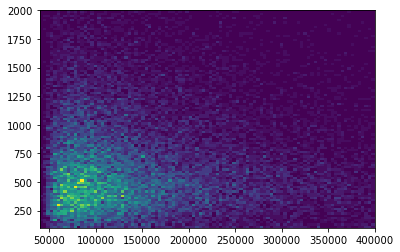

In [38]:
# mean CAPE vs max area.
plt.hist2d(np.nanmax(tracks.dstracks.area.values, axis=1), np.nanmean(track_era5.cape.values, axis=1), bins=(np.linspace(40000, 400000, 100), np.linspace(100, 2000, 100)));

# OLD CODE

In [39]:
raise Exception('No longer run!')
thresh = 0.1
growth_mask = fractional_area_growth >= 0.1
stable_mask = (fractional_area_growth > -0.1) & (fractional_area_growth < 0.1)
decay_mask = fractional_area_growth <= 0.1

Exception: No longer run!

In [77]:
thresh = 0.1  # roughly equal numbers in each.
growth_mask = fractional_area_growth > thresh
decay_mask = fractional_area_growth < -thresh
stable_mask = (fractional_area_growth >= -thresh) & (fractional_area_growth <= thresh)
print(growth_mask.sum())
print(stable_mask.sum())
print(decay_mask.sum())

257003
172820
201163


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.cape.values[m & mask]
    mean = data[data > 100].mean()
    p = plt.hist(data, bins=np.linspace(100, 3000, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = track_era5.tcwv.values[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 80, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


## Similar, but for shear at different levels.

In [ ]:
track_era5uv.level

In [ ]:
def calc_shear(track_era5uv):
    u = track_era5uv.u.values
    v = track_era5uv.v.values
    # Calc LLS, MLS, HLS, DS in one line.
    # LLS = shear[:, :, 0]
    # MLS = shear[:, :, 1]
    # HLS = shear[:, :, 2]
    # DS = shear[:, :, 3]
    shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
    return shear
    # lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [ ]:
def plot_shear(shear, mask, growth_mask, stable_mask, decay_mask, n=4):
    titles = {0: 'lls', 1: 'mls', 2: 'hls', 3: 'ds'}
    for i in range(n):
        sh = shear[:, :, i]
        plt.figure(figsize=(10, 8))
        plt.title(titles[i])
        for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
            data = sh[m & mask]
            mean = data.mean()
            p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
            plt.axvline(x=mean, color=c)
            print(mean)
        plt.legend()

In [ ]:
shear = calc_shear(track_era5uv)
plot_shear(shear, mask, growth_mask, stable_mask, decay_mask)

In [ ]:
# u = track_era5uv.u.values
# v = track_era5uv.v.values

In [ ]:
# u.shape

In [ ]:
# Calc LLS, MLS, HLS, DS in one line.
# LLS = shear[:, :, 0]
# MLS = shear[:, :, 1]
# HLS = shear[:, :, 2]
# DS = shear[:, :, 3]
# shear = np.sqrt((np.roll(u, -1, axis=2) - u)**2 + (np.roll(v, -1, axis=2) - v)**2)
# lls, mls, hls, ds = [shear[:, :, i] for i in range(4)]

In [ ]:
# for i in range(3):
#     print(np.sqrt((u[0, 0, i + 1] - u[0, 0, i])**2 + (v[0, 0, i + 1] - v[0, 0, i])**2))
# print(np.sqrt((u[0, 0, -1] - u[0, 0, 0])**2 + (v[0, 0, -1] - v[0, 0, 0])**2))

In [ ]:
# shear[0, 0, :]

In [ ]:
mask = ~np.isnan(lls)

In [ ]:
plt.hist(lls[mask], bins=100);

In [ ]:
plt.hist(mls[mask], bins=100);

In [ ]:
plt.hist(hls[mask], bins=100);

In [ ]:
plt.hist(ds[mask], bins=100);

In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = lls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = mls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = hls[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
plt.figure(figsize=(10, 8))
for l, m, c in [('growth', growth_mask, 'b'), ('stable', stable_mask, 'r'), ('decay', decay_mask, 'g')]:
    data = ds[m & mask]
    mean = data.mean()
    p = plt.hist(data, bins=np.linspace(0, 40, 200), histtype='step', density=True, label=l, color=c);
    plt.axvline(x=mean, color=c)
    print(mean)
plt.legend()


In [ ]:
tracks.dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    tropical_mask = ((tracks.dstracks.meanlat.values > -20) & (tracks.dstracks.meanlat.values < 20)).any(axis=1)
    eq_mask = ((tracks.dstracks.meanlat.values > -5) & (tracks.dstracks.meanlat.values < 5)).any(axis=1)
    dstracks_tropical = tracks.dstracks.isel(tracks=tropical_mask)
    dstracks_eq = tracks.dstracks.isel(tracks=eq_mask)
    
    track_era5uv_tropical = track_era5uv.sel(tracks=tropical_mask)
    track_era5uv_eq = track_era5uv.sel(tracks=eq_mask)
dstracks_tropical

In [ ]:
track_era5uv_eq

In [ ]:
def calc_frac_growth(dstracks):
    mask = ~np.isnan(dstracks.area)

    dt = 1
    fractional_area_growth = dstracks.area.values.copy()
    fractional_area_growth[:, 1:] = (1 / dstracks.area[:, 1:].values) * ((dstracks.area[:, 1:].values - dstracks.area[:, :-1].values) / dt)
    area_mask = mask.copy()
    area_mask[:, 0] = False
    return fractional_area_growth, area_mask

def calc_growth_masks(fractional_area_growth, thresh=0.1):
    growth_mask = fractional_area_growth >= 0.1
    stable_mask = (fractional_area_growth > -0.1) & (fractional_area_growth < 0.1)
    decay_mask = fractional_area_growth <= 0.1
    
    return growth_mask, stable_mask, decay_mask

In [ ]:
feg, feg_mask = calc_frac_growth(dstracks_tropical)
growth_mask, stable_mask, decay_mask = calc_growth_masks(feg)

shear = calc_shear(track_era5uv_tropical)
plot_shear(shear, feg_mask, growth_mask, stable_mask, decay_mask)

In [ ]:
feg, feg_mask = calc_frac_growth(dstracks_eq)
growth_mask, stable_mask, decay_mask = calc_growth_masks(feg)

shear = calc_shear(track_era5uv_eq)
plot_shear(shear, feg_mask, growth_mask, stable_mask, decay_mask)